<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction to Object Detection and Perform Basic Implementation of Object Detection using the R-CNN Approach


In [16]:
!pip install -q --upgrade selectivesearch torch_snippets


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.5 MB/s eta 0:00:00


In [17]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np

In [19]:
# Install required libraries (run this once)
!pip install -q --upgrade selectivesearch torch_snippets kagglehub

# Imports
import os
import pandas as pd
import kagglehub

from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Download the dataset via kagglehub
path = kagglehub.dataset_download("sixhky/open-images-bus-trucks")
print("Path to dataset files:", path)

# (Optional) See what is inside the dataset folder
# This helps confirm exact structure
import subprocess, textwrap
print("Dataset structure:")
print(subprocess.run(["ls", "-R", path], text=True, capture_output=True).stdout)

# Now set IMAGE_ROOT and DF_RAW similar to Kaggle, but using the actual path
# Adjust these if your ls -R output shows a slightly different structure
IMAGE_ROOT = os.path.join(path, "images", "images")   # usually images/images
DF_PATH    = os.path.join(path, "df.csv")             # csv file at root

print("IMAGE_ROOT:", IMAGE_ROOT)
print("DF_PATH:", DF_PATH)

# Load the dataframe
DF_RAW = pd.read_csv(DF_PATH)
print(DF_RAW.head())


Using device: cpu


100%|██████████| 367M/367M [00:09<00:00, 40.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sixhky/open-images-bus-trucks/versions/1
Dataset structure:
/root/.cache/kagglehub/datasets/sixhky/open-images-bus-trucks/versions/1:
df.csv
images

/root/.cache/kagglehub/datasets/sixhky/open-images-bus-trucks/versions/1/images:
images

/root/.cache/kagglehub/datasets/sixhky/open-images-bus-trucks/versions/1/images/images:
0000599864fd15b3.jpg
00006bdb1eb5cd74.jpg
00010bf498b64bab.jpg
00013f14dd4e168f.jpg
0002914fa805e227.jpg
00036603fa39fa85.jpg
0004d5a9dd44ab6a.jpg
0005f203463a13a8.jpg
00066517f9d814f9.jpg
00072b81abc72d21.jpg
000780f791b71252.jpg
0007eeeabf3c5e5c.jpg
000812dcf304a8e7.jpg
000817a6f6819e73.jpg
000924a411c24d25.jpg
0009b74be294a699.jpg
0009da46ef64adb7.jpg
0009ebddec6542a5.jpg
000d2e3d33b18463.jpg
000e83dc68db5ca8.jpg
001017b68b67625c.jpg
00118c8deaacd309.jpg
0011d11a6a5ab5ad.jpg
00120856d5e5a192.jpg
00121be7c1e76f83.jpg
0015ed86d644a332.jpg
00166578c691cd43.jpg
00192c1070c51ae3.jpg
001ae662d690368e.jpg
001bdbbf7a

In [20]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB
        # Basically x[...], it is similar to cv2.imread(image_path, 1)[:, :, ::-1], but this kinda works with any dimensions by mentioning just three dots
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #boxes in accordance to the image
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)

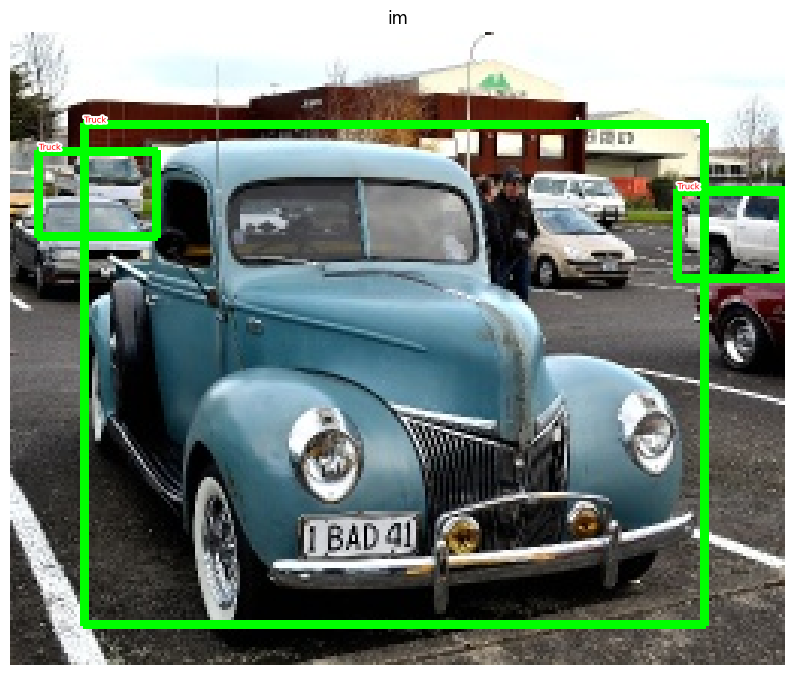

[[9, 39, 48, 67], [24, 30, 229, 195], [220, 52, 255, 81]]


In [23]:
import cv2
im, bbs, clss, _ = ds[6]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

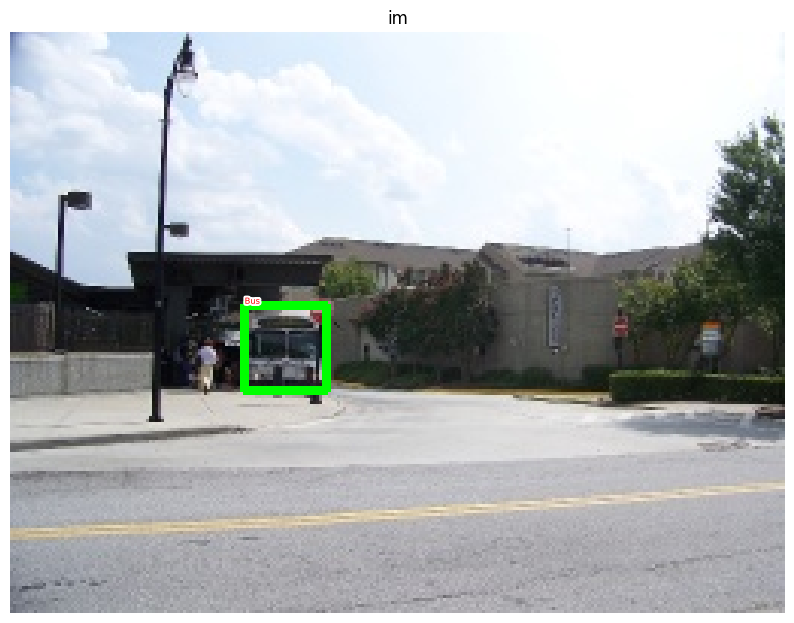

[[77, 90, 104, 118]]


In [24]:
im, bbs, clss, _ = ds[15]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

In [25]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

#how iou works
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)  #change in x-direction
    height = (y2 - y1)  #change in y-direction
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height # this was calculated by x1, y1, x2, y2
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

(38, 4)
<class 'list'>


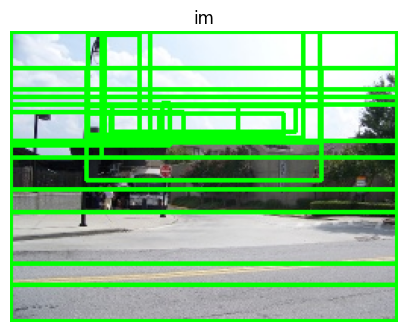

In [26]:
# Example of df[15]
candidates = extract_candidates(im)
print(np.shape(candidates))
print(type(candidates))
show(im, bbs = candidates)

In [27]:
help(show)

Help on function show in module torch_snippets.loader:

show(img=None, ax=None, title=None, sz=None, bbs=None, confs=None, texts=None, bb_colors=None, cmap='gray', grid: bool = False, save_path: str = None, text_sz: int = None, df: pandas.core.frame.DataFrame = None, pts=None, conns=None, interactive: bool = False, jitter: int = None, frame_count: int = 1, font_path=None, **kwargs)
    show an image



In [32]:
# Instead of: np.shape(ds[15])

im, bbs, labels, fpath = ds[15]
print(type(im), len(bbs), len(labels), fpath)
np.shape(np.array(ds[15], dtype=object))



<class 'numpy.ndarray'> 1 1 /root/.cache/kagglehub/datasets/sixhky/open-images-bus-trucks/versions/1/images/images/0009b74be294a699.jpg


(4,)

Best IoU: 0.14555256036666817


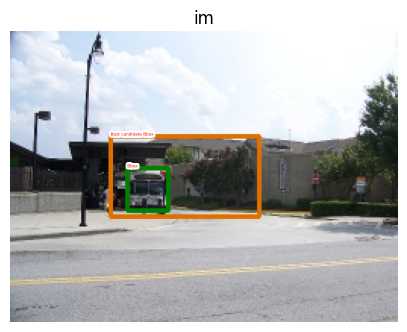

In [33]:
(im, bbs, labels, fpath) = ds[15]
H, W, _ = im.shape
candidates = extract_candidates(im)
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])  # candidates extracted are the x,y,w,h way and made x1, y1, x2, y2 to be similar to the bbs in the dataset

ious, rois, clss, deltas, best_ious = [], [], [], [], []
temp_best_bbs = []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

for jx, candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    candidate_ious = ious[jx]  #ious for that candidate
    best_iou_at = np.argmax(candidate_ious)  #best candidate iou is taken (index) ~ always be a zero index
    best_iou = candidate_ious[best_iou_at]   #gets the best score here
    best_ious.append(best_iou)
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # gets the target label bounding box where there is the highest iou
    temp_best_bbs.append(best_bb)
    if best_iou > 0.3: clss.append(labels[best_iou_at]) # if iou is more than 0.3 it is not the background
    else : clss.append('background')
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])  #normalizing the delta based on image size
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))

best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])


best_candidate = candidates[best_ious_at]
best_bbs = temp_best_bbs[best_ious_at]

# Example of df[15]
candidates = extract_candidates(im)
show(im, bbs = [best_bbs, best_candidate], confs= [0,0.5], texts = ['Bbox', 'Best candidate Bbox'])

In [34]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # if iou is more than 0.3 it is not the background
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]] #?

In [35]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']



print("The label to target values dictionary formed is:" ,label2target)

The label to target values dictionary formed is: {'Bus': 0, 'background': 1, 'Truck': 2}


In [36]:
# normalizing with the mean, std used while training the model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [37]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]  # bounding box image crops
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        '''Performing actions on a batch of images'''
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [38]:
n_train = 9*len(FPATHS)//10 # 0.9 is the train size
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [39]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False #not to do a re-train
vgg_backbone.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 62.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss() # loss for classification
        self.sl1 = nn.L1Loss() # loss for regression
    def forward(self, input):
        feat = self.backbone(input)  # both classification and regression takes 'feat' as input
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        # probs is basically the predicted class
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 1) #removing the label 1, which is background
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            # every ix is detected as background
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [41]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)  # as model outputs we will be getting classes and delta (bbox offsets)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [42]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)  # more like a softmax np argmax
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [43]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs) #records the metrics as report, can be used to plot later

In [45]:
import time
import torch.optim as optim

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)

n_epochs = 5                        # you still ask for max 5 epochs
log = Report(n_epochs)

# ---- Time limit in seconds (20 minutes) ----
MAX_TIME = 20 * 60                  # 20 minutes
start_time = time.time()

print(f"Training RCNN for up to {n_epochs} epochs OR {MAX_TIME/60:.0f} minutes (whichever comes first)\n")

# loc_loss: loss on classification
# regr_loss: loss on regression

for epoch in range(n_epochs):
    # If time is over, stop before starting next epoch
    if time.time() - start_time > MAX_TIME:
        print("\n⏹️ Time limit reached before starting epoch", epoch+1)
        break

    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # -------- TRAIN LOOP --------
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        # Check time during training
        if time.time() - start_time > MAX_TIME:
            print("\n⏹️ Time limit reached during training epoch", epoch+1)
            break

        loss, loc_loss, regr_loss, accs = train_batch(
            inputs, rcnn, optimizer, criterion
        )

        pos = epoch + (ix + 1) / _n
        log.record(pos,
                   trn_loss=loss.item(),
                   trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(),
                   end='\r')

    # If time is over after training loop, stop before validation
    if time.time() - start_time > MAX_TIME:
        break

    # -------- VALIDATION LOOP --------
    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        if time.time() - start_time > MAX_TIME:
            print("\n⏹️ Time limit reached during validation epoch", epoch+1)
            break

        _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(
            inputs, rcnn, criterion
        )

        pos = epoch + (ix + 1) / _n
        log.record(pos,
                   val_loss=loss.item(),
                   val_loc_loss=loc_loss,
                   val_regr_loss=regr_loss,
                   val_acc=accs.mean(),
                   end='\r')

    # If time is over after validation, stop overall
    if time.time() - start_time > MAX_TIME:
        break

print("\n✅ Training finished (either all epochs done or 20-minute limit reached).")


Training RCNN for up to 5 epochs OR 20 minutes (whichever comes first)


Epoch 1/5
EPOCH: 0.093  trn_loss: 3.779  trn_loc_loss: 0.660  trn_regr_loss: 0.312  trn_acc: 0.641  (1215.81s - 63917.04s remaining)
⏹️ Time limit reached during training epoch 1

✅ Training finished (either all epochs done or 20-minute limit reached).


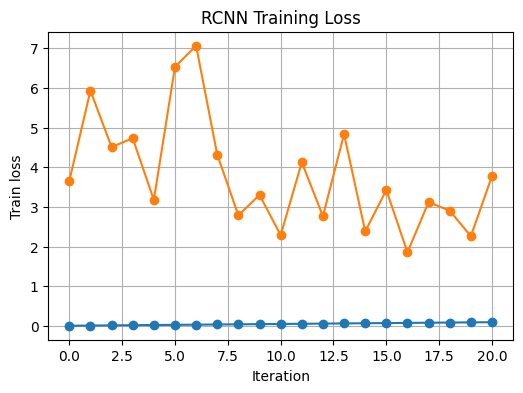

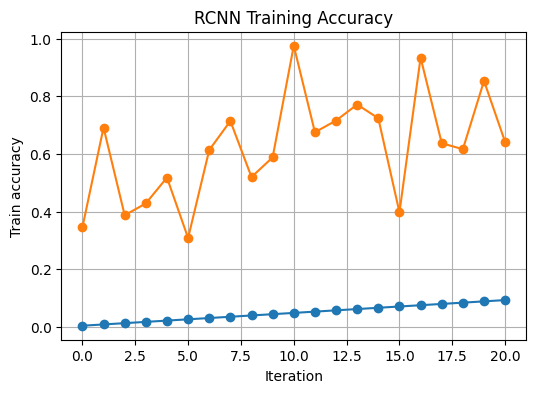

In [51]:
import matplotlib.pyplot as plt

# ---- Training loss ----
plt.figure(figsize=(6,4))
plt.plot(range(len(log.trn_loss)), log.trn_loss, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.title("RCNN Training Loss")
plt.grid(True)
plt.show()

# ---- Training accuracy ----
plt.figure(figsize=(6,4))
plt.plot(range(len(log.trn_acc)), log.trn_acc, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Train accuracy")
plt.title("RCNN Training Accuracy")
plt.grid(True)
plt.show()


In [52]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)  #Concatenates the given sequence of seq tensors in the given dimension
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        print("Shape of probs", np.shape(probs))
        print("Shape of deltas", np.shape(deltas))
        probs = torch.nn.functional.softmax(probs, -1)  # probability is put between 0 and 1 by doing a softmax
        confs, clss = torch.max(probs, -1) #-1 is the dimension in which the max (reduction) must happen -> confs tells me the confidence and clss tells me the class where it has found the max probs
        print("Shape of confs", np.shape(confs))
        print("Shape of clss", np.shape(clss))
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        # condition that even after nms, many ixs come for the bbox
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)  # index
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title('Predicted object: ' + target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

Shape of probs torch.Size([45, 3])
Shape of deltas torch.Size([45, 4])
Shape of confs torch.Size([45])
Shape of clss torch.Size([45])


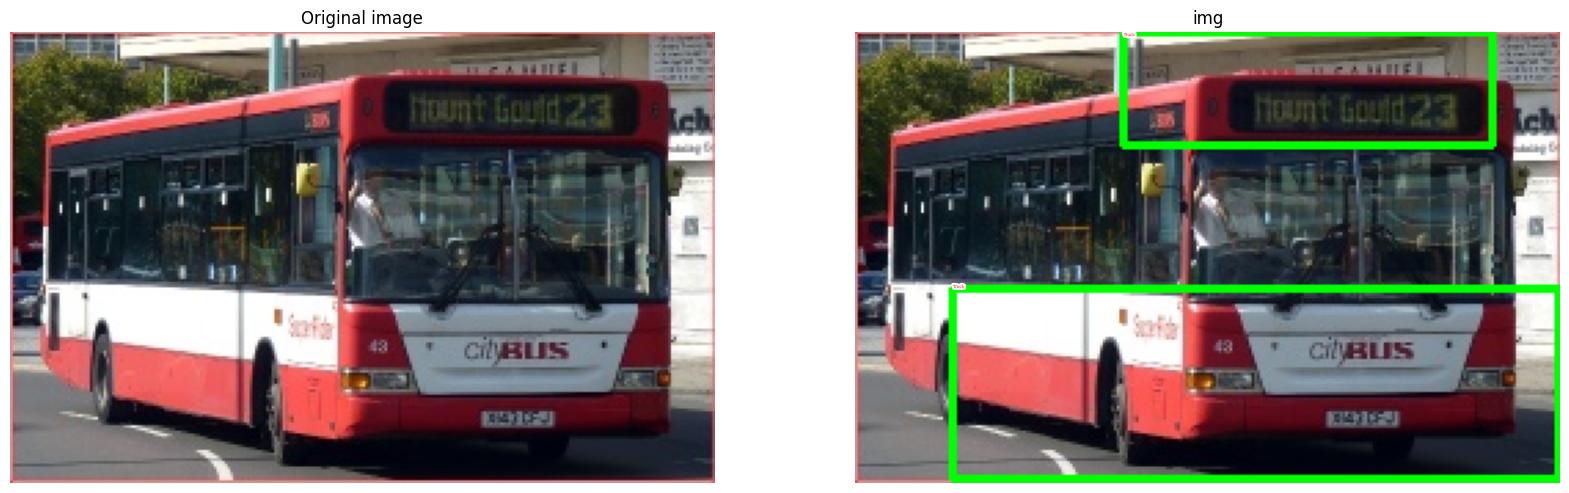

((np.uint16(35), np.uint16(93), np.uint16(255), np.uint16(162)),
 'Truck',
 np.float32(0.89679193))

In [53]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[6]
test_predictions(fpath)